In [12]:
%matplotlib inline

from GPy.models import GPRegression

from emukit.model_wrappers import GPyModelWrapper
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.experimental_design.model_free.latin_design import LatinDesign
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions import (
    NegativeLowerConfidenceBound as LCB,
    ExpectedImprovement as EI)

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

from l2_bayes_opt.acquisitions import (
    L2NegativeLowerConfidenceBound as L2_LCB,
    L2ExpectedImprovement as L2_EI)
from l2_bayes_opt.utils import BayesOptPlotter

np.random.seed(1)

$
\newcommand{\x}{\mathbf{x}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\N}{\mathcal{N}}
\newcommand{\e}{\epsilon}
\newcommand{\R}{\mathbb{R}}
\newcommand{\GP}{\mathcal{GP}}
\newcommand{\D}{\mathcal{D}}
$

# Background
This notebook demonstrates the method proposed in [Uhrenholt and Jensen, 2019] for target vector estimation using Bayesian optimization. Given a target vector $\y^* \in \R^K$ and multi-output function $h : \R^M \rightarrow \R^K$, which is assumed both noisy and blackboxed, we seek to find an optimal input $\hat\x$ such that $\y^* \approx h(\hat\x)$.

A straighforward approach would be to fit a probabilistic model, such as a Gaussian process model, directly to the squared Euclidean distance between target and function output, i.e.:
\begin{align*}
d &= \| h(\x) - \y^* \|^2_2,
\\
d &\sim \GP\left(0, \kappa(\x, \x')\right),
\end{align*}
and then subsequently minimize $d$ by standard Bayesian optimization.

In the proposed method we instead fit a separate model to each output dimension of $h$:
\begin{align*}
y_k &= h(\x)_k \sim \GP\left(0, \kappa_k(\x, \x')\right), \qquad 1 \le k \le K,
\end{align*}
yielding a predictive normal distribution for each dimension. Based on the dimensions' joint distribution we can infer an approximate noncentral Chi-squared distribution over $d$ and use this for a more accurate optimization.

# Example problem definition

Define noisy multi-output function

\begin{align*}
h(\mathbf{x}) &= \mathbf{y} =
\begin{bmatrix}
5 + \sin(x) + \epsilon_1 \\ 2 + 1.3\cos(x)+ \epsilon_2  \\ \tanh(x)+ \epsilon_3
\end{bmatrix}, \\
\epsilon_1, \epsilon_2, \epsilon_3 &\sim \mathcal{N}\left(0, 10^{-2}\right),
\end{align*}

and associated distance function

$$
d(\mathbf{x}) = \| d(\mathbf{x}) - \mathbf{y}^* \|^2_2,
$$

for target $\mathbf{y}^* = [4.5, 2, 0.8]^T$.

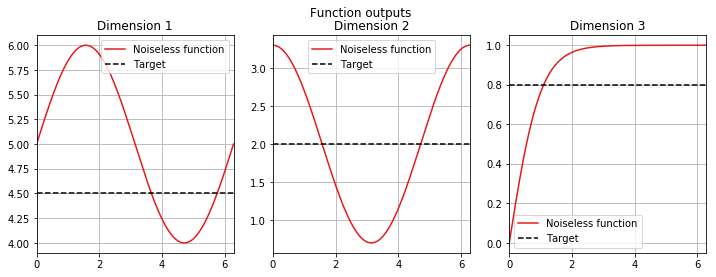

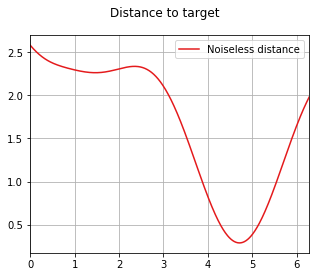

In [3]:
def h_noiseless(x):
    f1 = 5 + np.sin(x)
    f2 = 2 + 1.3 * np.cos(x)
    f3 = np.tanh(x)
    return np.hstack((f1, f2, f3))

def h(x):
    res = h_noiseless(x)
    return res + norm.rvs(scale=0.1, size=res.shape)

def d_noiseless(x):
    return ((h_noiseless(x) - target)**2).sum(axis=1)[:, None]

def d(x):
    return ((h(x) - target)**2).sum(axis=1)[:, None]

target = np.array([4.5, 2.0, 0.8])
xmin, xmax = 0, 2*np.pi

plotter = BayesOptPlotter(h_noiseless, target, xmin, xmax)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("Function outputs")
plotter.plot_function(axes)
plotter.decorate(axes)

fig, ax = plt.subplots(figsize=(5, 4))
fig.suptitle("Distance to target")
plotter.plot_distance(ax)
plotter.decorate(ax)

Sample 5 points by latin hypercube sampling and calculate associated function and distance values.

In [4]:
n_samples = 5
parameter_space = ParameterSpace([ContinuousParameter("x", xmin, xmax)])
latin_design = LatinDesign(parameter_space=parameter_space)
X0 = latin_design.get_samples(n_samples)
Y0 = h(X0)
D0 = ((Y0 - target)**2).sum(axis=1)
plotter = BayesOptPlotter(h_noiseless, target, xmin, xmax, X0=X0, Y0=Y0)

# Model comparison

### Standard GP model
Fit a GP directly to the sampled distances and plot the associated LCB acquisition utility. The utility reflects the prospect of sampling a given point, according to the model.

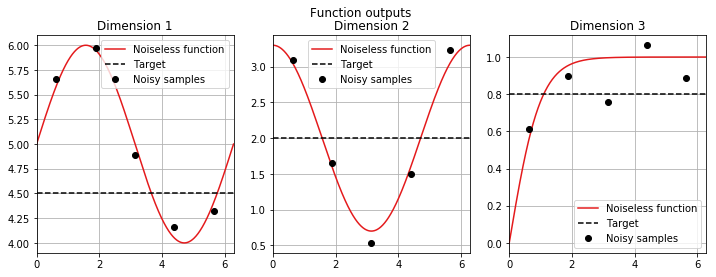

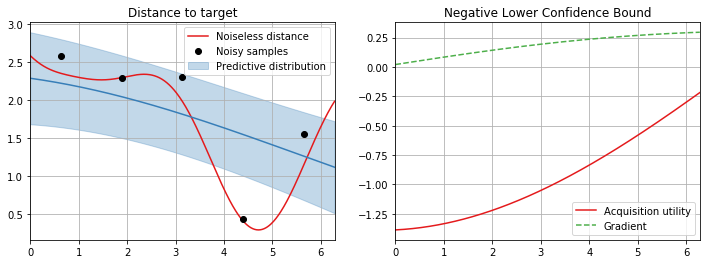

In [5]:
model = GPRegression(X0, D0[:, None])
model.optimize_restarts(verbose=False)
model_wrapped = GPyModelWrapper(model)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("Function outputs")
plotter.plot_function(axes)
plotter.decorate(axes)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.set_title("Distance to target")
plotter.plot_distance(ax1)
plotter.plot_distance_prediction(ax1, model, multi=False)

ax2.set_title("Negative Lower Confidence Bound")
acq = LCB(model=model_wrapped)
plotter.plot_acquisition(ax2, acq)
plotter.decorate([ax1, ax2])

### Proposed model

Fit a multi-output GP to the individual function output dimensions and use the predictive Chi-squared distribution for a more robust LCB acquisition utility.

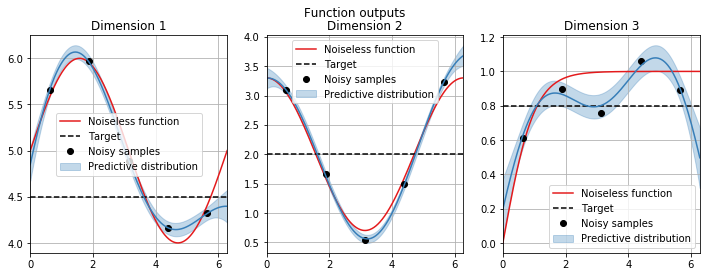

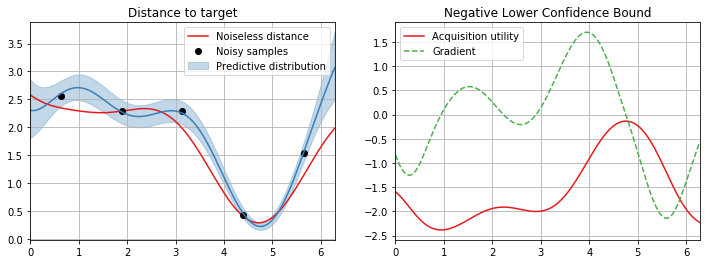

In [6]:
model = GPRegression(X0, Y0)
model.optimize_restarts(verbose=False)
model_wrapped = GPyModelWrapper(model)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("Function outputs")
plotter.plot_function(axes)
plotter.plot_function_predictions(axes, model)
plotter.decorate(axes)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.set_title("Distance to target")
plotter.plot_distance(ax1)
plotter.plot_distance_prediction(ax1, model, multi=True)

ax2.set_title("Negative Lower Confidence Bound")
acq = L2_LCB(model=model_wrapped, target=target)
plotter.plot_acquisition(ax2, acq)
plotter.decorate([ax1, ax2])

# Bayesian optimization

We use the Bayesian optimization framework from emukit [cite] to compare the two approaches. For each model we use the same 5 starting points and run 10 iterations. In each iteration the point to sample is selected by finding the input which maximizes the given acquisition function. The aim is to find the input which yields the lowest distance.

### Standard model

In [7]:
model = GPRegression(X0, D0[:, None])
model.optimize_restarts(verbose=False)
model_wrapped = GPyModelWrapper(model)
acq = LCB(model=model_wrapped)

fit_update = lambda a, b: model.optimize_restarts(verbose=False)
bayesopt_loop = BayesianOptimizationLoop(
    model=model_wrapped, space=parameter_space, acquisition=acq)
bayesopt_loop.iteration_end_event.append(fit_update)
bayesopt_loop.run_loop(d, 10)

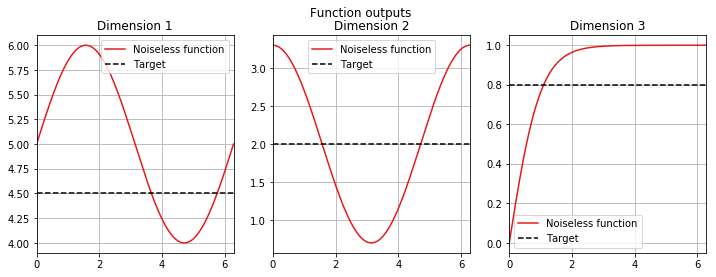

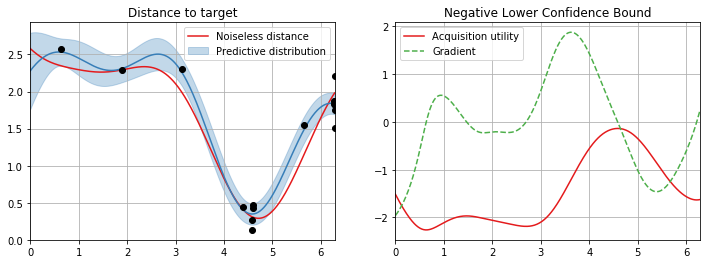

In [8]:
plotter = BayesOptPlotter(h_noiseless, target, xmin, xmax)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("Function outputs")
plotter.plot_function(axes, plot_samples=False)
plotter.decorate(axes)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.set_title("Distance to target")
plotter.plot_distance(ax1)
plotter.plot_distance_prediction(ax1, model, multi=False)
ax1.plot(model.X.ravel(), model.Y, "ko")

ax2.set_title("Negative Lower Confidence Bound")
plotter.plot_acquisition(ax2, acq)
plotter.decorate([ax1, ax2])

### Proposed model

In [9]:
model = GPRegression(X0, Y0)
model_wrapped = GPyModelWrapper(model)
acq = L2_LCB(model=model_wrapped, target=target)

fit_update = lambda a, b: model.optimize_restarts(verbose=False)
bayesopt_loop = BayesianOptimizationLoop(
    model=model_wrapped, space=parameter_space, acquisition=acq)
bayesopt_loop.iteration_end_event.append(fit_update)
bayesopt_loop.run_loop(h, 10)

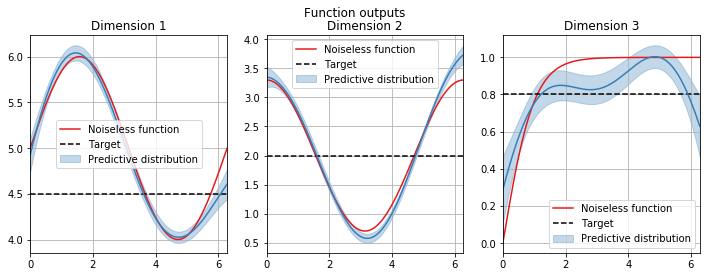

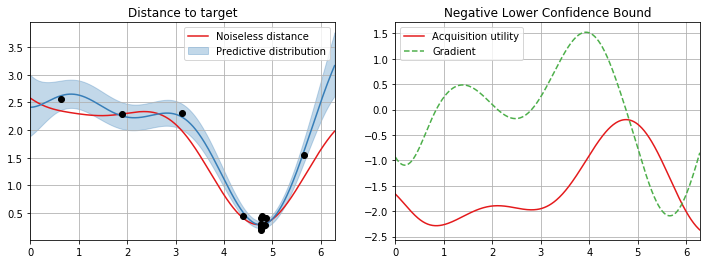

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("Function outputs")
plotter.plot_function(axes, plot_samples=False)
plotter.plot_function_predictions(axes, model)
plotter.decorate(axes)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.set_title("Distance to target")
plotter.plot_distance(ax1)
plotter.plot_distance_prediction(ax1, model, multi=True)
D = ((model.Y - target)**2).sum(axis=1)
ax1.plot(model.X.ravel(), D, "ko")

ax2.set_title("Negative Lower Confidence Bound")
plotter.plot_acquisition(ax2, acq)
plotter.decorate([ax1, ax2])